# Disciple - 取引シミュレーション（Jupyter用）

In [15]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_date_dir_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [16]:
# デバッグモード
debug = True

res = AppRes()
excel = "ticks_20260119.xlsx"
code = "7011"
# code = "7203"
# code = "8306"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
date_str = get_date_dir_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/01/19
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 50
PERIOD_MA_2 : 800
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.1
PERIOD_RR : 30
TURBULENCE : 35.0
LOSSCUT_1 : -25
THRESHOLD_PM_MIN : 10.0
THRESHOLD_DDR_MIN : 0.6
N_MINUS_MAX : 240


In [17]:
# 取引明細
df_transaction = app.getTransaction()
df_transaction["累積損益"] = df_transaction["損益"].fillna(0).cumsum()
print("取引明細")
print(df_transaction)
print(df_transaction["注文日時"].dtype)
print(df_transaction["累積損益"].dtype)

list_html = conv_transaction_df2html(df_transaction)

if debug:
    output_dir = os.path.join("tmp", date_str)
else:
    output_dir = os.path.join("output", date_str)

os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_transaction.html")
print(output)
with open(output, mode="w") as f:
    f.write("\n".join(list_html))

list_trans = df_transaction["注文日時"]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
    注文番号                          注文日時 銘柄コード  売買  約定単価  約定数量      損益 備考  \
0      1 2026-01-19 09:03:13.128850937  7011  買建  4642   100     NaN      
1      2 2026-01-19 09:27:19.505207062  7011  売埋  4727   100  8500.0      
2      3 2026-01-19 09:27:20.505347012  7011  売建  4726   100     NaN      
3      4 2026-01-19 09:35:44.658725977  7011  買埋  4738   100 -1200.0      
4      5 2026-01-19 09:35:45.677285910  7011  買建  4736   100     NaN      
5      6 2026-01-19 09:37:39.446569920  7011  売埋  4724   100 -1200.0      
6      7 2026-01-19 09:37:40.460210085  7011  売建  4724   100     NaN      
7      8 2026-01-19 09:38:59.962615013  7011  買埋  4737   100 -1300.0      
8      9 2026-01-19 09:39:00.966773033  7011  買建  4737   100     NaN      
9     10 2026-01-19 09:46:16.920772076  7011  売埋  4747   100  1000.0      
10    11 2026-01-19 09:55:45.919881105  7011  売建  4752   100     NaN      
11    12 2026-01-19 09:59:06.831926107  7011  買埋  4760   100  -800.0      
12    13 2026-01-19 

In [18]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [19]:
"""
累積損益のトレンドを作成するための準備
"""

# 元データ
ts = df_transaction["注文日時"]
pl = df_transaction["累積損益"]

# 日付（年月日）だけ取り出す
date = ts.iloc[0].normalize()

# 追加する先頭と末尾の行
start_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=9)],
        "累積損益": [0.0],
    }
)

end_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=15, minutes=30)],
        "累積損益": [pl.iloc[-1]],
    }
)

# トレンド用 DataFrame を作成
trend_df = pd.concat(
    [start_row, df_transaction[["注文日時", "累積損益"]], end_row], ignore_index=True
)

# 注文日時を index にした Series を作成
trend_series = trend_df.set_index("注文日時")["累積損益"]
trend_series

注文日時
2026-01-19 09:00:00.000000000        0.0
2026-01-19 09:03:13.128850937        0.0
2026-01-19 09:27:19.505207062     8500.0
2026-01-19 09:27:20.505347012     8500.0
2026-01-19 09:35:44.658725977     7300.0
2026-01-19 09:35:45.677285910     7300.0
2026-01-19 09:37:39.446569920     6100.0
2026-01-19 09:37:40.460210085     6100.0
2026-01-19 09:38:59.962615013     4800.0
2026-01-19 09:39:00.966773033     4800.0
2026-01-19 09:46:16.920772076     5800.0
2026-01-19 09:55:45.919881105     5800.0
2026-01-19 09:59:06.831926107     5000.0
2026-01-19 09:59:07.833971977     5000.0
2026-01-19 10:13:35.778507948     7100.0
2026-01-19 10:19:44.529259920     7100.0
2026-01-19 10:25:26.007548094     7800.0
2026-01-19 10:34:38.496028900     7800.0
2026-01-19 10:36:42.005047083     7400.0
2026-01-19 10:37:24.051738024     7400.0
2026-01-19 10:46:52.420958042     7900.0
2026-01-19 10:47:29.622522116     7900.0
2026-01-19 10:55:03.710273981     7100.0
2026-01-19 11:01:30.500808001     7100.0
2026-01-19 

tmp/2026/01/19/7011_trend_profit.png


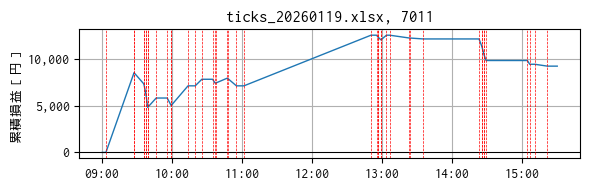

In [20]:
# 累積損益トレンド
fig, ax = plt.subplots(figsize=(6, 2))

ax.set_title(f"{excel}, {code}")
ax.plot(trend_series, linewidth=1)
ax.axhline(y=0, color="black", linewidth=0.75)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("累積損益［円］")
for t in list_trans:
    ax.axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)
ax.grid()

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_profit.png")
print(output)
plt.savefig(output)
plt.show()

In [21]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts  price          ma1          ma2  disparity  \
2026-01-19 09:00:09  1.768781e+09   4649  4649.000000  4649.000000   0.000000   
2026-01-19 09:00:10  1.768781e+09   4649  4649.000000  4649.000000   0.000000   
2026-01-19 09:00:11  1.768781e+09   4638  4645.333333  4645.333333   0.000000   
2026-01-19 09:00:12  1.768781e+09   4638  4643.500000  4643.500000   0.000000   
2026-01-19 09:00:13  1.768781e+09   4631  4641.000000  4641.000000   0.000000   
...                           ...    ...          ...          ...        ...   
2026-01-19 15:24:45  1.768804e+09   4875  4878.080000  4874.941250   0.000644   
2026-01-19 15:24:46  1.768804e+09   4876  4877.940000  4874.942500   0.000615   
2026-01-19 15:24:47  1.768804e+09   4876  4877.800000  4874.943750   0.000586   
2026-01-19 15:24:48  1.768804e+09   4876  4877.680000  4874.943750   0.000561   
2026-01-19 15:24:49  1.768804e+09   4876  4877.560000  4874.943750   0.000537   

                   

In [22]:
df_tech["slope1"].describe()

count    19392.000000
mean         0.070781
std          0.085272
min          0.000000
25%          0.020000
50%          0.045333
75%          0.089333
max          2.238889
Name: slope1, dtype: float64

tmp/2026/01/19/7011_trend_technical.png


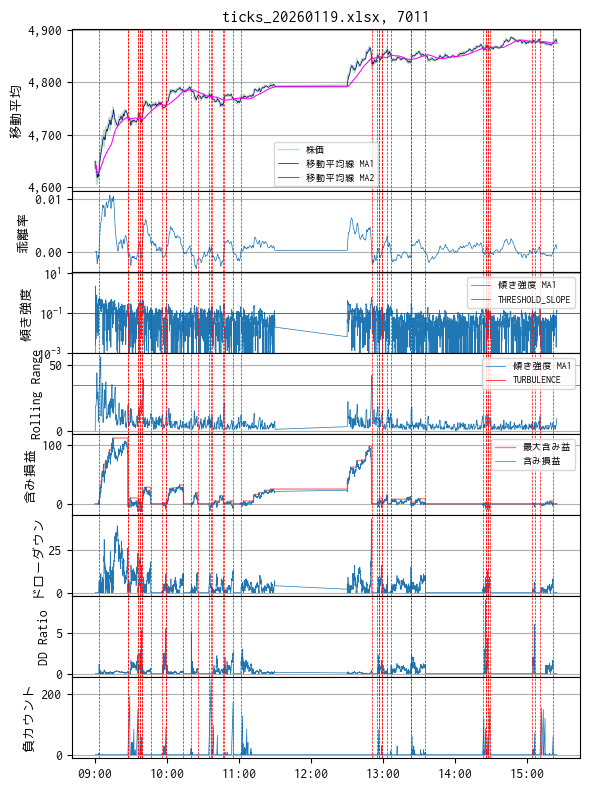

In [23]:
fig = plt.figure(figsize=(6, 8))
n = 8
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["price"], linewidth=1, color="green", alpha=0.25, label="株価")
ax[0].plot(df_tech["ma1"], linewidth=0.5, color="darkblue", label="移動平均線 MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["disparity"], linewidth=0.5, label="MA乖離率")
ax[1].set_ylabel("乖離率")

ax[2].plot(df_tech["slope1"], linewidth=0.5, label="傾き強度 MA1")
ax[2].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5, label="THRESHOLD_SLOPE")
ax[2].set_yscale("log")
ax[2].set_ylabel("傾き強度")
ax[2].legend(fontsize=7)
_, y_high = ax[2].get_ylim()
ax[2].set_ylim(0.001, y_high)

ax[3].plot(df_tech["rr"], linewidth=0.5, label="傾き強度 MA1")
ax[3].axhline(y=TURBULENCE, color="red", linewidth=0.5, label="TURBULENCE")
ax[3].set_ylabel("Rolling Range")
ax[3].legend(fontsize=7)

ax[4].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[4].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[4].set_ylabel("含み損益")
ax[4].legend(fontsize=7)

ax[5].plot(df_tech["drawdown"], linewidth=0.5)
ax[5].set_ylabel("ドローダウン")

ax[6].plot(df_tech["dd_ratio"], linewidth=0.5)
ax[6].set_ylabel("DD Ratio")

ax[7].plot(df_tech["n_minus"], linewidth=0.5)
ax[7].set_ylabel("負カウント")

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()

tmp/2026/01/19/7011_hist_slope.png


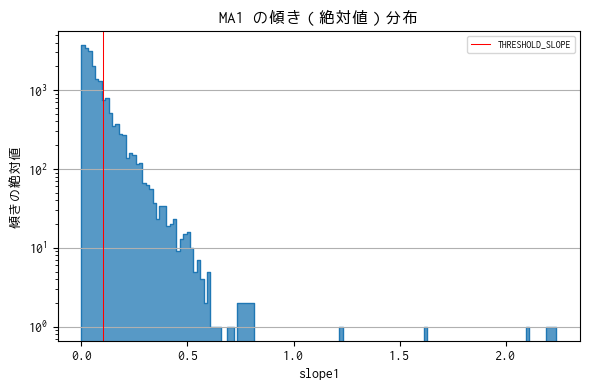

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_hist_slope.png")
print(output)
plt.savefig(output)
plt.show()

tmp/2026/01/19/7011_hist_rr.png


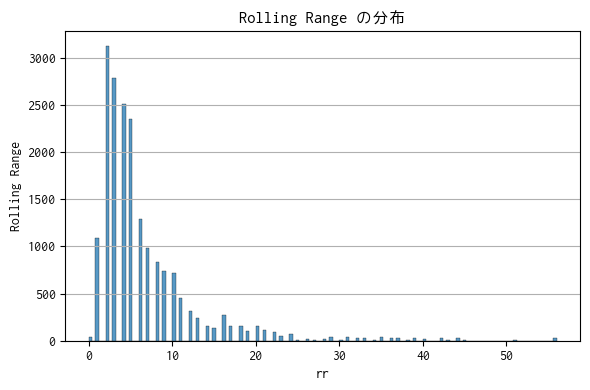

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Rolling Range の分布")
sns.histplot(data=df_tech, x="rr", bins="sqrt")
# ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
# ax.set_yscale("log")
ax.set_ylabel("Rolling Range")
ax.grid(axis="y")
# ax.legend(fontsize=7)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_hist_rr.png")
print(output)
plt.savefig(output)
plt.show()

In [26]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1  ロス2  利確1   建玉
2026-01-19 09:00:09    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-19 09:00:10    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-19 09:00:11    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-19 09:00:12    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-19 09:00:13    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...  ...  ...
2026-01-19 15:24:45    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-19 15:24:46    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-19 15:24:47    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-19 15:24:48    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-19 15:24:49    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0

[19392 rows x 8 columns]


tmp/2026/01/19/7011_trend_obs.png


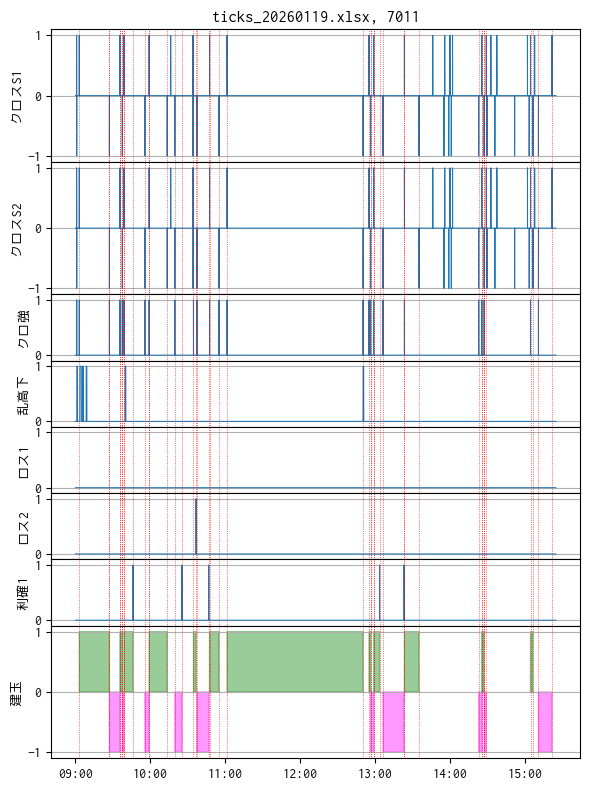

In [27]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()

targets = {"クロスS1", "クロスS2", "建玉"}
list_height_ratio = [2 if col in targets else 1 for col in df_obs.columns]
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=list_height_ratio)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

special_cross = {"クロスS1", "クロスS2"}

for i, colname in enumerate(df_obs.columns):
    ax_i = ax[i]

    if colname in special_cross:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-1.1, 1.1)

    elif colname == "建玉":
        x = df_obs.index
        y = df_obs[colname]
        ax_i.fill_between(
            x, 0, y, where=y > 0, color="green", alpha=0.4, interpolate=True
        )
        ax_i.fill_between(
            x, 0, y, where=y < 0, color="magenta", alpha=0.4, interpolate=True
        )
        ax_i.set_ylim(-1.1, 1.1)

    else:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-0.1, 1.1)

    ax_i.set_ylabel(colname)
    ax_i.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_obs.png")
print(output)
plt.tight_layout()
plt.savefig(output)
plt.show()